In [87]:
# !pip install transformers   #Installare libreria transformers per usare librerie di Bert
# !pip install pandas
# !pip install torch
# !pip install scipy
# !pip install scikit-learn
# !pip install ipywidgets
# !pip install matplotlib


In [88]:
import sys

sys.path.append('/home/michieletto/hmp_utils')
if '../' not in sys.path:
    sys.path.append('../')

In [89]:
import json
import glob
import os
import random

import sys

sys.path.append('/home/michieletto/hmp_utils') # Passaggio cartelle per trovare hmp_utils
if '../' not in sys.path:
    sys.path.append('../')

from hmp_utils.motion.body_models_constants import SmplConstants
from hmp_utils.motion.mocap_processor import MocapLoader
from hmp_utils.motion.kinematics import ForwardKinematics
from hmp_utils.visualize.stickman_animation import pose_animation, CameraOrientation, AnimationMode

from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import tqdm
import numpy as np
import pandas as pd
import wandb



In [90]:
wandb.login()

True

In [91]:
dataset = []

# Definisci il percorso completo del file JSON
percorso_file_train = '/home/michieletto/datasets/BABEL_DATASET/babel_v1.0_release/train.json'
percorso_file_val   = '/home/michieletto/datasets/BABEL_DATASET/babel_v1.0_release/val.json'
percorso_file_test  = '/home/michieletto/datasets/BABEL_DATASET/babel_v1.0_release/test.json'

dataset.append(percorso_file_train)
dataset.append(percorso_file_val)
dataset.append(percorso_file_test)

data = {}           # Dizionario contenente l'intero dataset  

# Apre il file JSON in modalità lettura
for i,percorso_file in enumerate(dataset):
    with open(percorso_file, 'r') as f:
        # Carica i dati JSON
        data.update(json.load(f))


In [92]:
occur_lab = {
    'label': [],               
    'feat_p': []
    } 

for i, k in enumerate(data.keys()):
    label = data[k]["seq_ann"]["labels"][0]["raw_label"]
    feat_p = data[k]["feat_p"]

    if label is not None and feat_p is not None:
        occur_lab["label"].append(label)
        occur_lab["feat_p"].append(feat_p)


In [93]:

directory = '/home/michieletto/datasets/AMASS_H/ACCAD'
file_paths = glob.glob(directory + '/**/*.npz', recursive=True) # ottiene tutti i file nelle diverse cartelle contenenti i mocap in una stringa

directory = '/home/michieletto/datasets/AMASS_H/KIT'
file_paths += glob.glob(directory + '/**/*.npz', recursive=True)

file_paths = sorted(file_paths)
print(len(file_paths))

rand_x = random.randint(0, len(file_paths))
filepath = file_paths[rand_x]

file_name = os.path.basename(filepath)    # ottiene il nome del file
folder_path = os.path.dirname(filepath)   # ottiene il percorso fino alla cartella in cui è contenuto il file
last_folder_name = os.path.basename(folder_path)     # ottiene il nome dell'ultima cartella
last_folder_and_file_name = os.path.join(last_folder_name, file_name)     # unisce i due nomi

for i in range(len(occur_lab["feat_p"])):
    if last_folder_and_file_name in occur_lab["feat_p"][i]:
        print(occur_lab["label"][i], occur_lab["feat_p"][i])


4484
walk KIT/KIT/205/walking_medium06_poses.npz


In [94]:

frame_to_plot = 0

# -- load mocap --
mocap_loader=MocapLoader(body_model_type=SmplConstants.BODY_MODEL_TYPE,
                         keypoint_ids_to_load=SmplConstants.KEYPOINTS,
                         target_framerate = 25)

motions = []
motions = [mocap_loader.load_mocap(path) for path in file_paths]     # lista delle classi di tutti i mocap

# -- compute joint positions --
kine = ForwardKinematics(SmplConstants.OFFSETS, SmplConstants.PARENTS)
kine.set_body_model_type(SmplConstants.BODY_MODEL_TYPE)

all_keypoints_positions = []
for i, motion in enumerate(motions):
    if motion is not None:
        all_keypoints_positions.append(kine.compute_fk(motion.rots, apply_root_rotation=True))

keypoints_positions = all_keypoints_positions[rand_x][frame_to_plot]

print(len(all_keypoints_positions))

# -- plot --
# plot_body_keypoints(keypoints_positions, SmplConstants.PARENTS, azimuth=0, keypoint_size = 5, link_size=1, 
#                     show_keypoint_id=True, body_rotation=(0,0,45))

4483


In [95]:
keypoints_positions = all_keypoints_positions[rand_x][:250]
print(keypoints_positions.shape)

motions_list = [keypoints_positions]
subplot_ids = [0]
subplot_titles = ['Amass']
camera_orientations = [CameraOrientation(100, 20)]
# pose_animation(motions_list, SmplConstants.PARENTS, animation_framerate = 60, subplot_ids=subplot_ids, 
#                camera_orientations=camera_orientations, subplot_titles=subplot_titles,
#                fig_opts={'dpi':90}, animation_mode=AnimationMode.HTML)

(103, 24, 3)


In [96]:
frame_vocab = []
deleted_paths = []
cont = 0

for i in range(len(motions)):
    if motions[i] is not None:
        if len(motions[i].rots) >= 75:
            rand_x = random.randint(0, len(motions[i].rots) - 75)
            frame_vocab.append(motions[i].rots[rand_x:rand_x + 75])
            assert len(frame_vocab[-1]) == 75

            frame_vocab[-1] = [[angle for k_point in frame for angle in k_point] for frame in frame_vocab[-1]]
            assert len(frame_vocab[-1][0]) == 72
        else:
            frame_vocab.append([])
            deleted_paths.append(i)
            cont += 1
    else:
        frame_vocab.append([])
        deleted_paths.append(i)
        cont += 1

sum = 0
for i in range(len(frame_vocab)):
    sum += len(frame_vocab[i])

print(f"Numero di mocap non validi: {cont}")
print(f"Il numero totale di frame è: {sum}")


Numero di mocap non validi: 131
Il numero totale di frame è: 326475


In [97]:
dataset = {
    'pose': [],
    'description': [],
}

for i in range(len(file_paths)):
    if i not in deleted_paths:
        filepath = file_paths[i]

        file_name = os.path.basename(filepath)    # ottiene il nome del file
        folder_path = os.path.dirname(filepath)   # ottiene il percorso fino alla cartella in cui è contenuto il file
        last_folder_name = os.path.basename(folder_path)     # ottiene il nome dell'ultima cartella
        last_folder_and_file_name = os.path.join('/', last_folder_name, file_name)     # unisce i due nomi
        
        for j in range(len(occur_lab["feat_p"])):
            if last_folder_and_file_name in occur_lab["feat_p"][j]:
                dataset["pose"].append(frame_vocab[i])
                dataset["description"].append(occur_lab["label"][j])

frame_vocab = pd.DataFrame(dataset["pose"])
frame_vocab_copy = frame_vocab.copy()

print(len(frame_vocab))
frame_vocab.iloc[35]

2726


0     [0.13654566924309341, 2.084810989515543, 2.215...
1     [0.135392748253839, 2.0836275157522497, 2.2119...
2     [0.13485865405946196, 2.083271838141371, 2.212...
3     [0.13775512050121025, 2.081980218524337, 2.212...
4     [0.13458242506610513, 2.083625728616343, 2.212...
                            ...                        
70    [0.13954880407233688, 2.076541321836611, 2.213...
71    [0.1424285858137265, 2.0741196875319194, 2.213...
72    [0.14128784764390498, 2.0743558015374504, 2.21...
73    [0.1434805544938584, 2.074369433460303, 2.2128...
74    [0.14243041662663503, 2.074396924214101, 2.212...
Name: 35, Length: 75, dtype: object

In [98]:
print(len(frame_vocab.iloc[0]), len(frame_vocab[0][0]))
print(len(frame_vocab_copy.iloc[0]), len(frame_vocab_copy[0][0]))

75 72
75 72


In [99]:
# Funzione per eliminare una colonna da ogni matrice
def elimina_colonna(matrice, indexes_to_exclude):

    return [np.delete(row, indexes_to_exclude) for row in matrice]

indexes_to_exclude = [0,1,2, 30,31,32, 33,34,35, 66,67,68, 69,70,71] # Indici corrispondenti ai keypoint 0,10,11,22,23
# Applica la funzione a ogni elemento del DataFrame
frame_vocab = frame_vocab.apply(elimina_colonna, indexes_to_exclude = indexes_to_exclude)

In [100]:
print(len(frame_vocab.iloc[0]), len(frame_vocab[0][0]))
print(len(frame_vocab_copy.iloc[0]), len(frame_vocab_copy[0][0]))

75 57
75 72


In [101]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# train_data, test_data = train_test_split(frame_vocab, test_size=0.2, random_state=RANDOM_SEED)
# valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=RANDOM_SEED)

# print(len(train_data), len(valid_data), len(test_data))


In [102]:
def get_collate_fn():
    def collate_fn(batch):
        batch = [[row[i] for row in batch] for i in range(len(batch[0]))]
        batch = np.array(batch)
        batch = torch.tensor(batch)
        batch = batch.float()
        
        return batch

    return collate_fn

In [103]:
def get_data_loader(dataset, batch_size, shuffle=False):
    collate_fn = get_collate_fn()
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    
    return data_loader

In [104]:
batch_size = 64

# train_data_loader = get_data_loader(train_data.values.tolist(), batch_size, shuffle=True)
# valid_data_loader = get_data_loader(valid_data.values.tolist(), batch_size)
# test_data_loader = get_data_loader(test_data.values.tolist(), batch_size)


# batch = next(iter(train_data_loader))
# print(type(batch), len(batch))
# print(type(batch[0]), len(batch[0]))
# print(type(batch[0][0]), len(batch[0][0]))


In [105]:
class Encoder(nn.Module):
    def __init__(self, dense_vector_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(dense_vector_dim, hidden_dim, n_layers, dropout=dropout)

    def forward(self, src):
        
        # src = [src length, batch size, dense_vector_dim]
        outputs, (hidden, cell) = self.rnn(src)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

In [106]:
class Decoder(nn.Module):
    def __init__(self, dense_vector_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = dense_vector_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(dense_vector_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, dense_vector_dim)

    def forward(self, input, hidden, cell):
        # input = [batch size, dense_vector_dim]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size, dense_vector_dim]
        output, (hidden, cell) = self.rnn(input, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        input = input.squeeze(0)
        prediction = input + prediction
        
        return prediction, hidden, cell

In [107]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size, dense_vector_dim]
        # trg = [trg length, batch size, dense_vector_dim]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]

        input = trg[0, :]
        # input = [batch size, output_dim]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # outputs = [trg_lenght, batch_size, dense_vector_dim]
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            # top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else output
            # input = [batch size]
        
        return outputs

In [108]:

dense_vector_encoder_dim = 57 
dense_vector_decoder_dim = 57 
hidden_dim = [512, 1024]
lr = [1e-4, 1e-3, 1e-2, 2e-5]
n_layers = [2, 3, 4, 1]
encoder_dropout = 0
decoder_dropout = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# encoder = Encoder(
#     dense_vector_encoder_dim,
#     hidden_dim,
#     n_layers,
#     encoder_dropout,
# )

# decoder = Decoder(
#     dense_vector_decoder_dim,
#     hidden_dim,
#     n_layers,
#     decoder_dropout,
# )

# model = Seq2Seq(encoder, decoder, device).to(device)

In [109]:
# def init_weights(m):
#     for name, param in m.named_parameters():
#         nn.init.uniform_(param.data, -0.08, 0.08)

# model.apply(init_weights)

In [110]:
# Number of iterations
EPOCHS = 500

# Optimizer Adam
# optimizer = optim.Adam(model.parameters(), lr=2e-5)

# total_steps = len(train_data_loader) * EPOCHS

# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=0,
#     num_training_steps=total_steps
# )

In [111]:
def train_fn(
    model, data_loader, optimizer, scheduler, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    num_mocap = 0
    for i, batch in enumerate(data_loader):
        src_lenght = 50
        trg_lenght = 25

        src = batch[:src_lenght].to(device)
        trg = batch[-trg_lenght:].to(device)
        # src = [src length, batch size, dense_vector_dim]
        # trg = [trg length, batch size, dense_vector_dim]
        
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, dense_vector_dim]
        output_dim = output.shape[-1]
        output = output[:].view(-1, output_dim)
        # output = [trg length * batch size, dense_vector_dim]
        trg = trg[:].view(-1, output_dim)
        # trg = [trg length * batch size, dense_vector_dim]
        loss = torch.square(output - trg)
        loss = torch.sum(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()  
        num_mocap += src.shape[1]

    return epoch_loss / num_mocap

In [112]:
def evaluate_fn(model, data_loader, device):
    model.eval()
    epoch_loss = 0.5
    num_mocap = 0.5
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src_lenght = 50
            trg_lenght = 25

            src = batch[:src_lenght].to(device)
            trg = batch[-trg_lenght:].to(device)
            # src = [src length, batch size, dense_vector_dim]
            # trg = [trg length, batch size, dense_vector_dim]

            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[:].view(-1, output_dim)
            # output = [trg length * batch size, trg vocab size]
            trg = trg[:].view(-1, output_dim)
            # trg = [trg length * batch size]
            loss = torch.square(output - trg)
            loss = torch.sum(loss)
            epoch_loss += loss.item()
            num_mocap += src.shape[1]

    return epoch_loss / num_mocap

In [113]:
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")
history = {
    "train_loss": [],
    "valid_loss": [],
    "losses": []
}

train_data, test_data = train_test_split(frame_vocab, test_size=0.2, random_state=RANDOM_SEED)
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=RANDOM_SEED)

train_data_loader = get_data_loader(train_data.values.tolist(), batch_size, shuffle=True)
valid_data_loader = get_data_loader(valid_data.values.tolist(), batch_size)
test_data_loader = get_data_loader(test_data.values.tolist(), batch_size)

all_seeds = [434345, 434345, 232, 875434, 3232356, 42, 645332, 67789, 3426, 2354]
for i in range(len(hidden_dim)):
    i =-1
    for j in range(len(lr)):
        j=-1
        for k in range(len(n_layers )):
            k=-1
            # dataset = dataset.sample(frac=1).reset_index(drop=True)
            print("Parametri utilizzati:")
            print("Hidden size encoder:", hidden_dim[i])
            print("Learning rate:", lr[j])
            print("Num layers:", n_layers[k])

            # run = wandb.init(
            #     # Set the project where this run will be logged
            #     project="without_description_plot",

            #     name=f"{hidden_dim[i]}_{lr[j]}_{n_layers[k]}",
            #     # Track hyperparameters and run metadata
            #     config={
            #         "hidden_size_encoder": hidden_dim[i],
            #         "learning_rate": lr[j],
            #         "num_layers": n_layers[k],
            #     },
            # )

            torch.manual_seed(RANDOM_SEED)

            encoder = Encoder(
            dense_vector_encoder_dim,
            hidden_dim[i],
            n_layers[k],
            encoder_dropout,
            )

            decoder = Decoder(
                dense_vector_decoder_dim,
                hidden_dim[i],
                n_layers[k],
                decoder_dropout,
            )

            model = Seq2Seq(encoder, decoder, device).to(device)
            optimizer = optim.Adam(model.parameters(), lr[j])

            total_steps = len(train_data_loader) * EPOCHS

            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=total_steps
            )
            
            for epoch in tqdm.tqdm(range(EPOCHS)):
                train_loss = train_fn(
                    model,
                    train_data_loader,
                    optimizer,
                    scheduler,
                    clip,
                    teacher_forcing_ratio,
                    device,
                )
                history["train_loss"].append(train_loss)

                valid_loss = evaluate_fn(
                    model,
                    valid_data_loader,
                    device,
                )
                history["valid_loss"].append(valid_loss)

                if valid_loss < best_valid_loss:
                    best_valid_loss = valid_loss
                    torch.save(model.state_dict(), "tut1-model.pt")
                print(f"\tTrain Loss: {train_loss:7.3f}")
                print(f"\tValid Loss: {valid_loss:7.3f}")

                # wandb.log({"validation error": valid_loss, "train error": train_loss})

            history["losses"].append(best_valid_loss)
            # print(f"Epoch {i+1}/10")
            # print(best_valid_loss)
            best_valid_loss = float("inf")
            break
        break
    break

Parametri utilizzati:
Hidden size encoder: 1024
Learning rate: 2e-05
Num layers: 1


  0%|          | 1/500 [00:01<11:22,  1.37s/it]

	Train Loss:   9.129
	Valid Loss:  41.323


  0%|          | 2/500 [00:02<11:12,  1.35s/it]

	Train Loss:   8.315
	Valid Loss:  30.669


  1%|          | 3/500 [00:04<11:08,  1.35s/it]

	Train Loss:   7.936
	Valid Loss:  26.938


  1%|          | 4/500 [00:05<11:06,  1.34s/it]

	Train Loss:   7.600
	Valid Loss:  25.341


  1%|          | 5/500 [00:06<11:17,  1.37s/it]

	Train Loss:   7.744
	Valid Loss:  24.482


  1%|          | 6/500 [00:08<11:22,  1.38s/it]

	Train Loss:   7.625
	Valid Loss:  23.948


  1%|▏         | 7/500 [00:09<11:24,  1.39s/it]

	Train Loss:   7.355
	Valid Loss:  23.627


  2%|▏         | 8/500 [00:11<11:26,  1.40s/it]

	Train Loss:   7.548
	Valid Loss:  23.454


  2%|▏         | 9/500 [00:12<11:26,  1.40s/it]

	Train Loss:   7.442
	Valid Loss:  23.370


  2%|▏         | 10/500 [00:13<11:25,  1.40s/it]

	Train Loss:   7.545
	Valid Loss:  23.192


  2%|▏         | 11/500 [00:14<10:31,  1.29s/it]

	Train Loss:   7.487
	Valid Loss:  23.210


  2%|▏         | 12/500 [00:16<10:45,  1.32s/it]

	Train Loss:   7.417
	Valid Loss:  23.044


  3%|▎         | 13/500 [00:17<10:56,  1.35s/it]

	Train Loss:   7.592
	Valid Loss:  22.969


  3%|▎         | 14/500 [00:18<10:11,  1.26s/it]

	Train Loss:   7.506
	Valid Loss:  23.087


  3%|▎         | 15/500 [00:19<09:38,  1.19s/it]

	Train Loss:   7.822
	Valid Loss:  22.994


  3%|▎         | 16/500 [00:21<10:06,  1.25s/it]

	Train Loss:   7.202
	Valid Loss:  22.924


  3%|▎         | 17/500 [00:22<10:28,  1.30s/it]

	Train Loss:   7.453
	Valid Loss:  22.908


  4%|▎         | 18/500 [00:23<10:34,  1.32s/it]

	Train Loss:   7.454
	Valid Loss:  22.801


  4%|▍         | 19/500 [00:24<09:45,  1.22s/it]

	Train Loss:   7.400
	Valid Loss:  22.847


  4%|▍         | 20/500 [00:26<09:59,  1.25s/it]

	Train Loss:   7.235
	Valid Loss:  22.758


  4%|▍         | 21/500 [00:27<10:21,  1.30s/it]

	Train Loss:   7.258
	Valid Loss:  22.635


  4%|▍         | 22/500 [00:28<09:33,  1.20s/it]

	Train Loss:   7.334
	Valid Loss:  22.636


  5%|▍         | 23/500 [00:29<09:51,  1.24s/it]

	Train Loss:   7.668
	Valid Loss:  22.581


  5%|▍         | 24/500 [00:31<10:03,  1.27s/it]

	Train Loss:   7.380
	Valid Loss:  22.533


  5%|▌         | 25/500 [00:32<10:12,  1.29s/it]

	Train Loss:   7.387
	Valid Loss:  22.526


  5%|▌         | 26/500 [00:33<10:17,  1.30s/it]

	Train Loss:   7.451
	Valid Loss:  22.335


  5%|▌         | 27/500 [00:34<09:30,  1.21s/it]

	Train Loss:   7.347
	Valid Loss:  22.365


  6%|▌         | 28/500 [00:36<09:46,  1.24s/it]

	Train Loss:   7.144
	Valid Loss:  22.243


  6%|▌         | 29/500 [00:37<09:08,  1.16s/it]

	Train Loss:   6.933
	Valid Loss:  22.266


  6%|▌         | 30/500 [00:38<08:40,  1.11s/it]

	Train Loss:   7.273
	Valid Loss:  22.266


  6%|▌         | 31/500 [00:39<09:12,  1.18s/it]

	Train Loss:   7.039
	Valid Loss:  22.061


  6%|▋         | 32/500 [00:40<09:34,  1.23s/it]

	Train Loss:   6.972
	Valid Loss:  22.009


  7%|▋         | 33/500 [00:42<09:58,  1.28s/it]

	Train Loss:   7.153
	Valid Loss:  21.974


  7%|▋         | 34/500 [00:43<10:14,  1.32s/it]

	Train Loss:   7.256
	Valid Loss:  21.913


  7%|▋         | 35/500 [00:45<10:25,  1.34s/it]

	Train Loss:   7.017
	Valid Loss:  21.887


  7%|▋         | 36/500 [00:46<10:32,  1.36s/it]

	Train Loss:   7.065
	Valid Loss:  21.801


  7%|▋         | 37/500 [00:47<10:37,  1.38s/it]

	Train Loss:   7.082
	Valid Loss:  21.793


  8%|▊         | 38/500 [00:49<10:30,  1.36s/it]

	Train Loss:   7.253
	Valid Loss:  21.688


  8%|▊         | 39/500 [00:50<09:34,  1.25s/it]

	Train Loss:   7.083
	Valid Loss:  21.696


  8%|▊         | 40/500 [00:51<09:45,  1.27s/it]

	Train Loss:   7.077
	Valid Loss:  21.629


  8%|▊         | 41/500 [00:52<09:03,  1.18s/it]

	Train Loss:   7.053
	Valid Loss:  21.735


  8%|▊         | 42/500 [00:53<09:22,  1.23s/it]

	Train Loss:   7.173
	Valid Loss:  21.575


  9%|▊         | 43/500 [00:55<09:36,  1.26s/it]

	Train Loss:   7.006
	Valid Loss:  21.526


  9%|▉         | 44/500 [00:56<08:55,  1.17s/it]

	Train Loss:   7.008
	Valid Loss:  21.734


  9%|▉         | 45/500 [00:57<09:14,  1.22s/it]

	Train Loss:   7.161
	Valid Loss:  21.497


  9%|▉         | 46/500 [00:58<08:39,  1.14s/it]

	Train Loss:   6.960
	Valid Loss:  21.520


  9%|▉         | 47/500 [00:59<09:03,  1.20s/it]

	Train Loss:   7.023
	Valid Loss:  21.496


 10%|▉         | 48/500 [01:00<08:30,  1.13s/it]

	Train Loss:   7.085
	Valid Loss:  21.659


 10%|▉         | 49/500 [01:01<08:08,  1.08s/it]

	Train Loss:   7.021
	Valid Loss:  21.546


 10%|█         | 50/500 [01:02<07:51,  1.05s/it]

	Train Loss:   6.813
	Valid Loss:  21.514


 10%|█         | 51/500 [01:03<07:40,  1.03s/it]

	Train Loss:   6.995
	Valid Loss:  21.562


 10%|█         | 52/500 [01:04<07:33,  1.01s/it]

	Train Loss:   7.174
	Valid Loss:  21.521


 11%|█         | 53/500 [01:05<07:29,  1.01s/it]

	Train Loss:   7.038
	Valid Loss:  21.563


 11%|█         | 54/500 [01:06<07:25,  1.00it/s]

	Train Loss:   7.169
	Valid Loss:  21.514


 11%|█         | 55/500 [01:07<07:23,  1.00it/s]

	Train Loss:   7.035
	Valid Loss:  21.526


 11%|█         | 56/500 [01:08<08:09,  1.10s/it]

	Train Loss:   7.047
	Valid Loss:  21.451


 11%|█▏        | 57/500 [01:09<07:54,  1.07s/it]

	Train Loss:   7.032
	Valid Loss:  21.467


 12%|█▏        | 58/500 [01:11<08:30,  1.15s/it]

	Train Loss:   7.064
	Valid Loss:  21.332


 12%|█▏        | 59/500 [01:12<08:08,  1.11s/it]

	Train Loss:   7.070
	Valid Loss:  21.381


 12%|█▏        | 60/500 [01:13<07:51,  1.07s/it]

	Train Loss:   6.937
	Valid Loss:  21.510


 12%|█▏        | 61/500 [01:14<07:39,  1.05s/it]

	Train Loss:   7.190
	Valid Loss:  21.368


 12%|█▏        | 62/500 [01:15<08:17,  1.14s/it]

	Train Loss:   6.873
	Valid Loss:  21.288


 13%|█▎        | 63/500 [01:16<07:56,  1.09s/it]

	Train Loss:   6.799
	Valid Loss:  21.450


 13%|█▎        | 64/500 [01:17<07:41,  1.06s/it]

	Train Loss:   7.079
	Valid Loss:  21.426


 13%|█▎        | 65/500 [01:18<07:31,  1.04s/it]

	Train Loss:   6.994
	Valid Loss:  21.392


 13%|█▎        | 66/500 [01:19<07:22,  1.02s/it]

	Train Loss:   6.938
	Valid Loss:  21.408


 13%|█▎        | 67/500 [01:20<08:04,  1.12s/it]

	Train Loss:   7.037
	Valid Loss:  21.278


 14%|█▎        | 68/500 [01:21<07:46,  1.08s/it]

	Train Loss:   6.993
	Valid Loss:  21.289


 14%|█▍        | 69/500 [01:22<07:32,  1.05s/it]

	Train Loss:   7.113
	Valid Loss:  21.339


 14%|█▍        | 70/500 [01:23<07:23,  1.03s/it]

	Train Loss:   6.744
	Valid Loss:  21.385


 14%|█▍        | 71/500 [01:24<07:16,  1.02s/it]

	Train Loss:   7.076
	Valid Loss:  21.361


 14%|█▍        | 72/500 [01:25<07:11,  1.01s/it]

	Train Loss:   6.852
	Valid Loss:  21.279


 15%|█▍        | 73/500 [01:27<07:53,  1.11s/it]

	Train Loss:   6.865
	Valid Loss:  21.221


 15%|█▍        | 74/500 [01:28<07:37,  1.07s/it]

	Train Loss:   6.839
	Valid Loss:  21.551


 15%|█▌        | 75/500 [01:29<07:25,  1.05s/it]

	Train Loss:   6.917
	Valid Loss:  21.281


 15%|█▌        | 76/500 [01:30<07:16,  1.03s/it]

	Train Loss:   7.028
	Valid Loss:  21.540


 15%|█▌        | 77/500 [01:31<07:09,  1.01s/it]

	Train Loss:   6.760
	Valid Loss:  21.294


 16%|█▌        | 78/500 [01:32<07:03,  1.00s/it]

	Train Loss:   7.057
	Valid Loss:  21.334


 16%|█▌        | 79/500 [01:33<07:45,  1.11s/it]

	Train Loss:   6.863
	Valid Loss:  21.150


 16%|█▌        | 80/500 [01:34<07:30,  1.07s/it]

	Train Loss:   7.024
	Valid Loss:  21.286


 16%|█▌        | 81/500 [01:35<07:18,  1.05s/it]

	Train Loss:   6.943
	Valid Loss:  21.356


 16%|█▋        | 82/500 [01:36<07:10,  1.03s/it]

	Train Loss:   6.951
	Valid Loss:  21.308


 17%|█▋        | 83/500 [01:37<07:03,  1.02s/it]

	Train Loss:   6.826
	Valid Loss:  21.152


 17%|█▋        | 84/500 [01:38<06:58,  1.01s/it]

	Train Loss:   6.909
	Valid Loss:  21.262


 17%|█▋        | 85/500 [01:39<06:54,  1.00it/s]

	Train Loss:   6.821
	Valid Loss:  21.245


 17%|█▋        | 86/500 [01:40<06:52,  1.00it/s]

	Train Loss:   6.795
	Valid Loss:  21.189


 17%|█▋        | 87/500 [01:41<06:50,  1.01it/s]

	Train Loss:   6.905
	Valid Loss:  21.292


 18%|█▊        | 88/500 [01:42<07:32,  1.10s/it]

	Train Loss:   6.851
	Valid Loss:  21.056


 18%|█▊        | 89/500 [01:43<07:18,  1.07s/it]

	Train Loss:   6.953
	Valid Loss:  21.345


 18%|█▊        | 90/500 [01:45<07:51,  1.15s/it]

	Train Loss:   6.972
	Valid Loss:  21.021


 18%|█▊        | 91/500 [01:46<07:30,  1.10s/it]

	Train Loss:   7.022
	Valid Loss:  21.243


 18%|█▊        | 92/500 [01:47<07:14,  1.07s/it]

	Train Loss:   6.853
	Valid Loss:  21.048


 19%|█▊        | 93/500 [01:48<07:03,  1.04s/it]

	Train Loss:   6.831
	Valid Loss:  21.482


 19%|█▉        | 94/500 [01:49<06:55,  1.02s/it]

	Train Loss:   6.772
	Valid Loss:  21.228


 19%|█▉        | 95/500 [01:50<07:32,  1.12s/it]

	Train Loss:   6.899
	Valid Loss:  20.971


 19%|█▉        | 96/500 [01:51<07:25,  1.10s/it]

	Train Loss:   6.837
	Valid Loss:  21.137


 19%|█▉        | 97/500 [01:52<07:20,  1.09s/it]

	Train Loss:   6.745
	Valid Loss:  21.198


 20%|█▉        | 98/500 [01:53<07:15,  1.08s/it]

	Train Loss:   6.765
	Valid Loss:  21.046


 20%|█▉        | 99/500 [01:54<07:11,  1.07s/it]

	Train Loss:   6.771
	Valid Loss:  21.238


 20%|██        | 100/500 [01:55<07:10,  1.08s/it]

	Train Loss:   6.753
	Valid Loss:  21.285


 20%|██        | 101/500 [01:56<07:08,  1.07s/it]

	Train Loss:   6.778
	Valid Loss:  21.083


 20%|██        | 102/500 [01:57<07:03,  1.06s/it]

	Train Loss:   6.705
	Valid Loss:  21.114


 21%|██        | 103/500 [01:58<06:59,  1.06s/it]

	Train Loss:   6.833
	Valid Loss:  20.982


 21%|██        | 104/500 [01:59<06:58,  1.06s/it]

	Train Loss:   6.956
	Valid Loss:  21.270


 21%|██        | 105/500 [02:00<06:56,  1.06s/it]

	Train Loss:   6.754
	Valid Loss:  21.016


 21%|██        | 106/500 [02:02<07:36,  1.16s/it]

	Train Loss:   6.799
	Valid Loss:  20.952


 21%|██▏       | 107/500 [02:03<07:15,  1.11s/it]

	Train Loss:   6.676
	Valid Loss:  21.001


 22%|██▏       | 108/500 [02:04<06:59,  1.07s/it]

	Train Loss:   6.966
	Valid Loss:  21.281


 22%|██▏       | 109/500 [02:05<06:48,  1.04s/it]

	Train Loss:   6.729
	Valid Loss:  21.047


 22%|██▏       | 110/500 [02:06<07:22,  1.13s/it]

	Train Loss:   6.938
	Valid Loss:  20.879


 22%|██▏       | 111/500 [02:07<07:08,  1.10s/it]

	Train Loss:   6.930
	Valid Loss:  21.151


 22%|██▏       | 112/500 [02:08<06:58,  1.08s/it]

	Train Loss:   6.856
	Valid Loss:  20.884


 23%|██▎       | 113/500 [02:09<06:50,  1.06s/it]

	Train Loss:   6.975
	Valid Loss:  21.536


 23%|██▎       | 114/500 [02:11<07:29,  1.16s/it]

	Train Loss:   6.796
	Valid Loss:  20.859


 23%|██▎       | 115/500 [02:12<07:14,  1.13s/it]

	Train Loss:   6.938
	Valid Loss:  21.049


 23%|██▎       | 116/500 [02:13<07:45,  1.21s/it]

	Train Loss:   6.840
	Valid Loss:  20.836


 23%|██▎       | 117/500 [02:14<07:24,  1.16s/it]

	Train Loss:   6.813
	Valid Loss:  20.842


 24%|██▎       | 118/500 [02:15<07:10,  1.13s/it]

	Train Loss:   6.797
	Valid Loss:  21.125


 24%|██▍       | 119/500 [02:16<06:59,  1.10s/it]

	Train Loss:   6.792
	Valid Loss:  20.876


 24%|██▍       | 120/500 [02:17<06:51,  1.08s/it]

	Train Loss:   6.759
	Valid Loss:  21.051


 24%|██▍       | 121/500 [02:19<07:26,  1.18s/it]

	Train Loss:   6.798
	Valid Loss:  20.803


 24%|██▍       | 122/500 [02:20<07:52,  1.25s/it]

	Train Loss:   6.957
	Valid Loss:  20.742


 25%|██▍       | 123/500 [02:21<07:28,  1.19s/it]

	Train Loss:   6.803
	Valid Loss:  20.874


 25%|██▍       | 124/500 [02:22<07:11,  1.15s/it]

	Train Loss:   6.825
	Valid Loss:  21.064


 25%|██▌       | 125/500 [02:23<06:59,  1.12s/it]

	Train Loss:   6.691
	Valid Loss:  20.774


 25%|██▌       | 126/500 [02:24<06:50,  1.10s/it]

	Train Loss:   6.935
	Valid Loss:  21.025


 25%|██▌       | 127/500 [02:25<06:43,  1.08s/it]

	Train Loss:   6.694
	Valid Loss:  20.848


 26%|██▌       | 128/500 [02:26<06:37,  1.07s/it]

	Train Loss:   6.701
	Valid Loss:  21.020


 26%|██▌       | 129/500 [02:27<06:33,  1.06s/it]

	Train Loss:   6.766
	Valid Loss:  20.822


 26%|██▌       | 130/500 [02:28<06:30,  1.06s/it]

	Train Loss:   6.755
	Valid Loss:  21.015


 26%|██▌       | 131/500 [02:29<06:27,  1.05s/it]

	Train Loss:   6.601
	Valid Loss:  20.927


 26%|██▋       | 132/500 [02:31<06:26,  1.05s/it]

	Train Loss:   6.818
	Valid Loss:  20.836


 27%|██▋       | 133/500 [02:32<06:24,  1.05s/it]

	Train Loss:   6.665
	Valid Loss:  20.812


 27%|██▋       | 134/500 [02:33<06:23,  1.05s/it]

	Train Loss:   6.855
	Valid Loss:  20.941


 27%|██▋       | 135/500 [02:34<07:01,  1.15s/it]

	Train Loss:   6.756
	Valid Loss:  20.630


 27%|██▋       | 136/500 [02:35<06:48,  1.12s/it]

	Train Loss:   6.684
	Valid Loss:  20.794


 27%|██▋       | 137/500 [02:36<07:18,  1.21s/it]

	Train Loss:   6.803
	Valid Loss:  20.592


 28%|██▊       | 138/500 [02:37<06:54,  1.14s/it]

	Train Loss:   6.636
	Valid Loss:  20.917


 28%|██▊       | 139/500 [02:38<06:35,  1.10s/it]

	Train Loss:   6.722
	Valid Loss:  20.751


 28%|██▊       | 140/500 [02:39<06:23,  1.07s/it]

	Train Loss:   6.740
	Valid Loss:  20.648


 28%|██▊       | 141/500 [02:40<06:20,  1.06s/it]

	Train Loss:   6.698
	Valid Loss:  21.097


 28%|██▊       | 142/500 [02:42<06:20,  1.06s/it]

	Train Loss:   6.736
	Valid Loss:  20.730


 29%|██▊       | 143/500 [02:43<06:18,  1.06s/it]

	Train Loss:   6.728
	Valid Loss:  20.829


 29%|██▉       | 144/500 [02:44<06:17,  1.06s/it]

	Train Loss:   6.770
	Valid Loss:  20.777


 29%|██▉       | 145/500 [02:45<06:15,  1.06s/it]

	Train Loss:   6.815
	Valid Loss:  20.822


 29%|██▉       | 146/500 [02:46<06:51,  1.16s/it]

	Train Loss:   6.605
	Valid Loss:  20.557


 29%|██▉       | 147/500 [02:47<06:39,  1.13s/it]

	Train Loss:   6.729
	Valid Loss:  20.816


 30%|██▉       | 148/500 [02:48<06:31,  1.11s/it]

	Train Loss:   6.666
	Valid Loss:  20.896


 30%|██▉       | 149/500 [02:49<06:24,  1.09s/it]

	Train Loss:   6.594
	Valid Loss:  21.239


 30%|███       | 150/500 [02:50<06:18,  1.08s/it]

	Train Loss:   6.717
	Valid Loss:  20.751


 30%|███       | 151/500 [02:51<06:15,  1.07s/it]

	Train Loss:   6.793
	Valid Loss:  20.675


 30%|███       | 152/500 [02:52<06:11,  1.07s/it]

	Train Loss:   6.638
	Valid Loss:  20.761


 31%|███       | 153/500 [02:54<06:09,  1.06s/it]

	Train Loss:   6.669
	Valid Loss:  20.716


 31%|███       | 154/500 [02:55<06:46,  1.18s/it]

	Train Loss:   6.641
	Valid Loss:  20.452


 31%|███       | 155/500 [02:56<06:35,  1.15s/it]

	Train Loss:   6.609
	Valid Loss:  20.522


 31%|███       | 156/500 [02:57<06:25,  1.12s/it]

	Train Loss:   6.679
	Valid Loss:  20.860


 31%|███▏      | 157/500 [02:58<06:17,  1.10s/it]

	Train Loss:   6.793
	Valid Loss:  20.579


 32%|███▏      | 158/500 [02:59<06:10,  1.08s/it]

	Train Loss:   6.661
	Valid Loss:  20.775


 32%|███▏      | 159/500 [03:00<06:05,  1.07s/it]

	Train Loss:   6.675
	Valid Loss:  20.815


 32%|███▏      | 160/500 [03:01<06:01,  1.06s/it]

	Train Loss:   6.748
	Valid Loss:  21.282


 32%|███▏      | 161/500 [03:02<05:58,  1.06s/it]

	Train Loss:   6.806
	Valid Loss:  20.653


 32%|███▏      | 162/500 [03:03<05:54,  1.05s/it]

	Train Loss:   6.698
	Valid Loss:  20.788


 33%|███▎      | 163/500 [03:04<05:45,  1.03s/it]

	Train Loss:   6.684
	Valid Loss:  20.662


 33%|███▎      | 164/500 [03:05<05:40,  1.01s/it]

	Train Loss:   6.563
	Valid Loss:  20.660


 33%|███▎      | 165/500 [03:06<05:35,  1.00s/it]

	Train Loss:   6.529
	Valid Loss:  20.644


 33%|███▎      | 166/500 [03:07<05:31,  1.01it/s]

	Train Loss:   6.821
	Valid Loss:  20.964


 33%|███▎      | 167/500 [03:08<05:28,  1.01it/s]

	Train Loss:   6.793
	Valid Loss:  20.722


 34%|███▎      | 168/500 [03:09<05:26,  1.02it/s]

	Train Loss:   6.641
	Valid Loss:  20.875


 34%|███▍      | 169/500 [03:10<05:26,  1.01it/s]

	Train Loss:   6.673
	Valid Loss:  21.460


 34%|███▍      | 170/500 [03:11<05:26,  1.01it/s]

	Train Loss:   6.729
	Valid Loss:  20.844


 34%|███▍      | 171/500 [03:12<05:25,  1.01it/s]

	Train Loss:   6.679
	Valid Loss:  20.753


 34%|███▍      | 172/500 [03:13<05:24,  1.01it/s]

	Train Loss:   6.680
	Valid Loss:  20.725


 35%|███▍      | 173/500 [03:14<05:24,  1.01it/s]

	Train Loss:   6.661
	Valid Loss:  20.522


 35%|███▍      | 174/500 [03:15<05:23,  1.01it/s]

	Train Loss:   6.666
	Valid Loss:  20.899


 35%|███▌      | 175/500 [03:16<05:22,  1.01it/s]

	Train Loss:   6.791
	Valid Loss:  20.807


 35%|███▌      | 176/500 [03:17<05:21,  1.01it/s]

	Train Loss:   6.646
	Valid Loss:  20.680


 35%|███▌      | 177/500 [03:18<05:19,  1.01it/s]

	Train Loss:   6.836
	Valid Loss:  20.561


 36%|███▌      | 178/500 [03:19<05:18,  1.01it/s]

	Train Loss:   6.675
	Valid Loss:  20.831


 36%|███▌      | 179/500 [03:20<05:17,  1.01it/s]

	Train Loss:   6.708
	Valid Loss:  20.667


 36%|███▌      | 180/500 [03:21<05:15,  1.01it/s]

	Train Loss:   6.632
	Valid Loss:  20.676


 36%|███▌      | 181/500 [03:22<05:15,  1.01it/s]

	Train Loss:   6.607
	Valid Loss:  21.394


 36%|███▋      | 182/500 [03:23<05:14,  1.01it/s]

	Train Loss:   6.687
	Valid Loss:  20.730


 37%|███▋      | 183/500 [03:24<05:13,  1.01it/s]

	Train Loss:   6.650
	Valid Loss:  20.843


 37%|███▋      | 184/500 [03:25<05:12,  1.01it/s]

	Train Loss:   6.842
	Valid Loss:  20.726


 37%|███▋      | 185/500 [03:26<05:10,  1.01it/s]

	Train Loss:   6.581
	Valid Loss:  20.790


 37%|███▋      | 186/500 [03:27<05:09,  1.01it/s]

	Train Loss:   6.565
	Valid Loss:  20.850


 37%|███▋      | 187/500 [03:28<05:08,  1.02it/s]

	Train Loss:   6.816
	Valid Loss:  20.835


 38%|███▊      | 188/500 [03:29<05:06,  1.02it/s]

	Train Loss:   6.597
	Valid Loss:  20.713


 38%|███▊      | 189/500 [03:30<05:05,  1.02it/s]

	Train Loss:   6.595
	Valid Loss:  20.633


 38%|███▊      | 190/500 [03:31<05:03,  1.02it/s]

	Train Loss:   6.750
	Valid Loss:  20.591


 38%|███▊      | 191/500 [03:32<05:01,  1.02it/s]

	Train Loss:   6.608
	Valid Loss:  20.685


 38%|███▊      | 192/500 [03:33<05:00,  1.03it/s]

	Train Loss:   6.635
	Valid Loss:  20.542


 39%|███▊      | 193/500 [03:34<04:58,  1.03it/s]

	Train Loss:   6.711
	Valid Loss:  20.602


 39%|███▉      | 194/500 [03:35<04:57,  1.03it/s]

	Train Loss:   6.657
	Valid Loss:  21.080


 39%|███▉      | 195/500 [03:36<04:57,  1.03it/s]

	Train Loss:   6.622
	Valid Loss:  20.791


 39%|███▉      | 196/500 [03:37<05:03,  1.00it/s]

	Train Loss:   6.675
	Valid Loss:  20.631


 39%|███▉      | 197/500 [03:38<05:06,  1.01s/it]

	Train Loss:   6.720
	Valid Loss:  20.685


 40%|███▉      | 198/500 [03:39<05:08,  1.02s/it]

	Train Loss:   6.682
	Valid Loss:  20.806


 40%|███▉      | 199/500 [03:40<05:08,  1.03s/it]

	Train Loss:   6.511
	Valid Loss:  20.565


 40%|████      | 200/500 [03:41<05:09,  1.03s/it]

	Train Loss:   6.610
	Valid Loss:  20.717


 40%|████      | 201/500 [03:42<05:09,  1.03s/it]

	Train Loss:   6.592
	Valid Loss:  20.769


 40%|████      | 202/500 [03:43<05:08,  1.04s/it]

	Train Loss:   6.736
	Valid Loss:  20.553


 41%|████      | 203/500 [03:44<05:08,  1.04s/it]

	Train Loss:   6.538
	Valid Loss:  20.538


 41%|████      | 204/500 [03:45<05:07,  1.04s/it]

	Train Loss:   6.679
	Valid Loss:  20.582


 41%|████      | 205/500 [03:46<05:06,  1.04s/it]

	Train Loss:   6.714
	Valid Loss:  20.848


 41%|████      | 206/500 [03:47<05:05,  1.04s/it]

	Train Loss:   6.619
	Valid Loss:  20.753


 41%|████▏     | 207/500 [03:48<05:04,  1.04s/it]

	Train Loss:   6.534
	Valid Loss:  20.748


 42%|████▏     | 208/500 [03:49<05:03,  1.04s/it]

	Train Loss:   6.535
	Valid Loss:  20.619


 42%|████▏     | 209/500 [03:51<05:34,  1.15s/it]

	Train Loss:   6.575
	Valid Loss:  20.445


 42%|████▏     | 210/500 [03:52<05:24,  1.12s/it]

	Train Loss:   6.544
	Valid Loss:  20.636


 42%|████▏     | 211/500 [03:53<05:17,  1.10s/it]

	Train Loss:   6.801
	Valid Loss:  20.677


 42%|████▏     | 212/500 [03:54<05:11,  1.08s/it]

	Train Loss:   6.575
	Valid Loss:  20.533


 43%|████▎     | 213/500 [03:55<05:38,  1.18s/it]

	Train Loss:   6.566
	Valid Loss:  20.362


 43%|████▎     | 214/500 [03:56<05:24,  1.13s/it]

	Train Loss:   6.653
	Valid Loss:  20.586


 43%|████▎     | 215/500 [03:57<05:14,  1.10s/it]

	Train Loss:   6.656
	Valid Loss:  20.559


 43%|████▎     | 216/500 [03:58<05:08,  1.09s/it]

	Train Loss:   6.734
	Valid Loss:  20.710


 43%|████▎     | 217/500 [03:59<05:03,  1.07s/it]

	Train Loss:   6.804
	Valid Loss:  20.603


 44%|████▎     | 218/500 [04:00<05:00,  1.07s/it]

	Train Loss:   6.613
	Valid Loss:  20.648


 44%|████▍     | 219/500 [04:02<04:57,  1.06s/it]

	Train Loss:   6.727
	Valid Loss:  21.138


 44%|████▍     | 220/500 [04:03<04:55,  1.06s/it]

	Train Loss:   6.675
	Valid Loss:  20.435


 44%|████▍     | 221/500 [04:04<04:53,  1.05s/it]

	Train Loss:   6.597
	Valid Loss:  20.602


 44%|████▍     | 222/500 [04:05<04:52,  1.05s/it]

	Train Loss:   6.506
	Valid Loss:  20.467


 45%|████▍     | 223/500 [04:06<04:51,  1.05s/it]

	Train Loss:   6.599
	Valid Loss:  20.767


 45%|████▍     | 224/500 [04:07<04:48,  1.05s/it]

	Train Loss:   6.800
	Valid Loss:  20.730


 45%|████▌     | 225/500 [04:08<04:46,  1.04s/it]

	Train Loss:   6.650
	Valid Loss:  20.625


 45%|████▌     | 226/500 [04:09<04:44,  1.04s/it]

	Train Loss:   6.496
	Valid Loss:  20.576


 45%|████▌     | 227/500 [04:10<04:42,  1.03s/it]

	Train Loss:   6.555
	Valid Loss:  20.514


 46%|████▌     | 228/500 [04:11<04:40,  1.03s/it]

	Train Loss:   6.533
	Valid Loss:  20.575


 46%|████▌     | 229/500 [04:12<04:39,  1.03s/it]

	Train Loss:   6.666
	Valid Loss:  20.617


 46%|████▌     | 230/500 [04:13<04:37,  1.03s/it]

	Train Loss:   6.728
	Valid Loss:  20.475


 46%|████▌     | 231/500 [04:14<04:36,  1.03s/it]

	Train Loss:   6.510
	Valid Loss:  20.638


 46%|████▋     | 232/500 [04:15<04:34,  1.03s/it]

	Train Loss:   6.651
	Valid Loss:  20.546


 47%|████▋     | 233/500 [04:16<04:33,  1.02s/it]

	Train Loss:   6.513
	Valid Loss:  20.581


 47%|████▋     | 234/500 [04:17<04:32,  1.02s/it]

	Train Loss:   6.594
	Valid Loss:  20.431


 47%|████▋     | 235/500 [04:18<04:31,  1.02s/it]

	Train Loss:   6.658
	Valid Loss:  20.642


 47%|████▋     | 236/500 [04:19<04:30,  1.03s/it]

	Train Loss:   6.569
	Valid Loss:  20.630


 47%|████▋     | 237/500 [04:20<04:29,  1.02s/it]

	Train Loss:   6.683
	Valid Loss:  20.591


 48%|████▊     | 238/500 [04:21<04:28,  1.02s/it]

	Train Loss:   6.575
	Valid Loss:  20.594


 48%|████▊     | 239/500 [04:22<04:27,  1.02s/it]

	Train Loss:   6.635
	Valid Loss:  20.618


 48%|████▊     | 240/500 [04:23<04:26,  1.02s/it]

	Train Loss:   6.554
	Valid Loss:  20.759


 48%|████▊     | 241/500 [04:24<04:25,  1.02s/it]

	Train Loss:   6.692
	Valid Loss:  20.565


 48%|████▊     | 242/500 [04:25<04:24,  1.02s/it]

	Train Loss:   6.606
	Valid Loss:  20.483


 49%|████▊     | 243/500 [04:26<04:23,  1.02s/it]

	Train Loss:   6.676
	Valid Loss:  20.631


 49%|████▉     | 244/500 [04:27<04:22,  1.02s/it]

	Train Loss:   6.613
	Valid Loss:  20.795


 49%|████▉     | 245/500 [04:28<04:22,  1.03s/it]

	Train Loss:   6.663
	Valid Loss:  20.702


 49%|████▉     | 246/500 [04:29<04:22,  1.03s/it]

	Train Loss:   6.574
	Valid Loss:  20.687


 49%|████▉     | 247/500 [04:30<04:22,  1.04s/it]

	Train Loss:   6.552
	Valid Loss:  20.759


 50%|████▉     | 248/500 [04:31<04:21,  1.04s/it]

	Train Loss:   6.567
	Valid Loss:  20.655


 50%|████▉     | 249/500 [04:32<04:21,  1.04s/it]

	Train Loss:   6.595
	Valid Loss:  20.677


 50%|█████     | 250/500 [04:34<04:20,  1.04s/it]

	Train Loss:   6.772
	Valid Loss:  20.594


 50%|█████     | 251/500 [04:35<04:20,  1.04s/it]

	Train Loss:   6.631
	Valid Loss:  20.706


 50%|█████     | 252/500 [04:36<04:19,  1.05s/it]

	Train Loss:   6.614
	Valid Loss:  20.600


 51%|█████     | 253/500 [04:37<04:18,  1.04s/it]

	Train Loss:   6.473
	Valid Loss:  20.868


 51%|█████     | 254/500 [04:38<04:16,  1.04s/it]

	Train Loss:   6.755
	Valid Loss:  20.395


 51%|█████     | 255/500 [04:39<04:16,  1.05s/it]

	Train Loss:   6.621
	Valid Loss:  20.679


 51%|█████     | 256/500 [04:40<04:14,  1.04s/it]

	Train Loss:   6.620
	Valid Loss:  20.801


 51%|█████▏    | 257/500 [04:41<04:14,  1.05s/it]

	Train Loss:   6.627
	Valid Loss:  20.830


 52%|█████▏    | 258/500 [04:42<04:12,  1.04s/it]

	Train Loss:   6.466
	Valid Loss:  20.621


 52%|█████▏    | 259/500 [04:43<04:11,  1.04s/it]

	Train Loss:   6.498
	Valid Loss:  20.774


 52%|█████▏    | 260/500 [04:44<04:10,  1.04s/it]

	Train Loss:   6.422
	Valid Loss:  20.507


 52%|█████▏    | 261/500 [04:45<04:09,  1.04s/it]

	Train Loss:   6.535
	Valid Loss:  20.627


 52%|█████▏    | 262/500 [04:46<04:08,  1.04s/it]

	Train Loss:   6.541
	Valid Loss:  20.566


 53%|█████▎    | 263/500 [04:47<04:07,  1.04s/it]

	Train Loss:   6.636
	Valid Loss:  20.577


 53%|█████▎    | 264/500 [04:48<04:06,  1.04s/it]

	Train Loss:   6.594
	Valid Loss:  20.978


 53%|█████▎    | 265/500 [04:49<04:05,  1.04s/it]

	Train Loss:   6.619
	Valid Loss:  20.623


 53%|█████▎    | 266/500 [04:50<04:03,  1.04s/it]

	Train Loss:   6.646
	Valid Loss:  20.638


 53%|█████▎    | 267/500 [04:51<04:03,  1.04s/it]

	Train Loss:   6.503
	Valid Loss:  20.428


 54%|█████▎    | 268/500 [04:52<04:02,  1.04s/it]

	Train Loss:   6.512
	Valid Loss:  20.571


 54%|█████▍    | 269/500 [04:53<04:01,  1.04s/it]

	Train Loss:   6.488
	Valid Loss:  20.515


 54%|█████▍    | 270/500 [04:54<03:59,  1.04s/it]

	Train Loss:   6.492
	Valid Loss:  20.442


 54%|█████▍    | 271/500 [04:55<03:58,  1.04s/it]

	Train Loss:   6.574
	Valid Loss:  20.608


 54%|█████▍    | 272/500 [04:56<03:57,  1.04s/it]

	Train Loss:   6.488
	Valid Loss:  20.512


 55%|█████▍    | 273/500 [04:58<03:56,  1.04s/it]

	Train Loss:   6.541
	Valid Loss:  21.059


 55%|█████▍    | 274/500 [04:59<03:55,  1.04s/it]

	Train Loss:   6.484
	Valid Loss:  20.649


 55%|█████▌    | 275/500 [05:00<03:54,  1.04s/it]

	Train Loss:   6.530
	Valid Loss:  20.496


 55%|█████▌    | 276/500 [05:01<03:53,  1.04s/it]

	Train Loss:   6.534
	Valid Loss:  20.564


 55%|█████▌    | 277/500 [05:02<03:52,  1.04s/it]

	Train Loss:   6.541
	Valid Loss:  20.444


 56%|█████▌    | 278/500 [05:03<03:52,  1.05s/it]

	Train Loss:   6.638
	Valid Loss:  20.524


 56%|█████▌    | 279/500 [05:04<03:51,  1.05s/it]

	Train Loss:   6.569
	Valid Loss:  20.422


 56%|█████▌    | 280/500 [05:05<03:50,  1.05s/it]

	Train Loss:   6.493
	Valid Loss:  20.729


 56%|█████▌    | 281/500 [05:06<03:49,  1.05s/it]

	Train Loss:   6.688
	Valid Loss:  20.663


 56%|█████▋    | 282/500 [05:07<03:48,  1.05s/it]

	Train Loss:   6.572
	Valid Loss:  20.723


 57%|█████▋    | 283/500 [05:08<03:46,  1.05s/it]

	Train Loss:   6.388
	Valid Loss:  20.718


 57%|█████▋    | 284/500 [05:09<03:45,  1.05s/it]

	Train Loss:   6.411
	Valid Loss:  20.615


 57%|█████▋    | 285/500 [05:10<03:44,  1.05s/it]

	Train Loss:   6.697
	Valid Loss:  20.812


 57%|█████▋    | 286/500 [05:11<03:43,  1.05s/it]

	Train Loss:   6.464
	Valid Loss:  20.696


 57%|█████▋    | 287/500 [05:12<03:39,  1.03s/it]

	Train Loss:   6.608
	Valid Loss:  20.544


 58%|█████▊    | 288/500 [05:13<03:35,  1.02s/it]

	Train Loss:   6.511
	Valid Loss:  20.711


 58%|█████▊    | 289/500 [05:14<03:32,  1.01s/it]

	Train Loss:   6.439
	Valid Loss:  20.589


 58%|█████▊    | 290/500 [05:15<03:29,  1.00it/s]

	Train Loss:   6.579
	Valid Loss:  20.837


 58%|█████▊    | 291/500 [05:16<03:27,  1.01it/s]

	Train Loss:   6.509
	Valid Loss:  20.488


 58%|█████▊    | 292/500 [05:17<03:26,  1.01it/s]

	Train Loss:   6.505
	Valid Loss:  20.616


 59%|█████▊    | 293/500 [05:18<03:27,  1.00s/it]

	Train Loss:   6.714
	Valid Loss:  20.829


 59%|█████▉    | 294/500 [05:19<03:28,  1.01s/it]

	Train Loss:   6.580
	Valid Loss:  20.740


 59%|█████▉    | 295/500 [05:20<03:28,  1.02s/it]

	Train Loss:   6.518
	Valid Loss:  20.653


 59%|█████▉    | 296/500 [05:21<03:27,  1.02s/it]

	Train Loss:   6.568
	Valid Loss:  20.754


 59%|█████▉    | 297/500 [05:22<03:27,  1.02s/it]

	Train Loss:   6.523
	Valid Loss:  20.762


 60%|█████▉    | 298/500 [05:23<03:26,  1.02s/it]

	Train Loss:   6.644
	Valid Loss:  21.015


 60%|█████▉    | 299/500 [05:24<03:25,  1.02s/it]

	Train Loss:   6.469
	Valid Loss:  20.697


 60%|██████    | 300/500 [05:25<03:25,  1.03s/it]

	Train Loss:   6.653
	Valid Loss:  20.610


 60%|██████    | 301/500 [05:26<03:25,  1.03s/it]

	Train Loss:   6.593
	Valid Loss:  20.860


 60%|██████    | 302/500 [05:27<03:25,  1.04s/it]

	Train Loss:   6.551
	Valid Loss:  20.518


 61%|██████    | 303/500 [05:29<03:46,  1.15s/it]

	Train Loss:   6.607
	Valid Loss:  20.354


 61%|██████    | 304/500 [05:30<03:39,  1.12s/it]

	Train Loss:   6.459
	Valid Loss:  20.502


 61%|██████    | 305/500 [05:31<03:34,  1.10s/it]

	Train Loss:   6.526
	Valid Loss:  20.654


 61%|██████    | 306/500 [05:32<03:30,  1.08s/it]

	Train Loss:   6.563
	Valid Loss:  20.712


 61%|██████▏   | 307/500 [05:33<03:27,  1.08s/it]

	Train Loss:   6.644
	Valid Loss:  20.655


 62%|██████▏   | 308/500 [05:34<03:25,  1.07s/it]

	Train Loss:   6.558
	Valid Loss:  20.557


 62%|██████▏   | 309/500 [05:35<03:23,  1.06s/it]

	Train Loss:   6.525
	Valid Loss:  20.495


 62%|██████▏   | 310/500 [05:36<03:21,  1.06s/it]

	Train Loss:   6.697
	Valid Loss:  20.701


 62%|██████▏   | 311/500 [05:37<03:19,  1.06s/it]

	Train Loss:   6.482
	Valid Loss:  21.012


 62%|██████▏   | 312/500 [05:38<03:18,  1.05s/it]

	Train Loss:   6.465
	Valid Loss:  20.597


 63%|██████▎   | 313/500 [05:39<03:16,  1.05s/it]

	Train Loss:   6.573
	Valid Loss:  20.642


 63%|██████▎   | 314/500 [05:40<03:15,  1.05s/it]

	Train Loss:   6.489
	Valid Loss:  20.567


 63%|██████▎   | 315/500 [05:41<03:13,  1.05s/it]

	Train Loss:   6.449
	Valid Loss:  20.906


 63%|██████▎   | 316/500 [05:42<03:12,  1.05s/it]

	Train Loss:   6.533
	Valid Loss:  20.875


 63%|██████▎   | 317/500 [05:43<03:11,  1.05s/it]

	Train Loss:   6.466
	Valid Loss:  20.883


 64%|██████▎   | 318/500 [05:44<03:10,  1.05s/it]

	Train Loss:   6.592
	Valid Loss:  20.661


 64%|██████▍   | 319/500 [05:46<03:09,  1.05s/it]

	Train Loss:   6.478
	Valid Loss:  20.622


 64%|██████▍   | 320/500 [05:47<03:08,  1.05s/it]

	Train Loss:   6.439
	Valid Loss:  20.751


 64%|██████▍   | 321/500 [05:48<03:06,  1.04s/it]

	Train Loss:   6.550
	Valid Loss:  20.377


 64%|██████▍   | 322/500 [05:49<03:04,  1.04s/it]

	Train Loss:   6.494
	Valid Loss:  20.661


 65%|██████▍   | 323/500 [05:50<03:03,  1.03s/it]

	Train Loss:   6.537
	Valid Loss:  20.790


 65%|██████▍   | 324/500 [05:51<03:01,  1.03s/it]

	Train Loss:   6.501
	Valid Loss:  20.628


 65%|██████▌   | 325/500 [05:52<03:00,  1.03s/it]

	Train Loss:   6.518
	Valid Loss:  20.571


 65%|██████▌   | 326/500 [05:53<02:58,  1.03s/it]

	Train Loss:   6.451
	Valid Loss:  20.608


 65%|██████▌   | 327/500 [05:54<02:57,  1.03s/it]

	Train Loss:   6.608
	Valid Loss:  20.733


 66%|██████▌   | 328/500 [05:55<02:56,  1.03s/it]

	Train Loss:   6.683
	Valid Loss:  20.446


 66%|██████▌   | 329/500 [05:56<02:56,  1.03s/it]

	Train Loss:   6.585
	Valid Loss:  20.605


 66%|██████▌   | 330/500 [05:57<02:55,  1.03s/it]

	Train Loss:   6.425
	Valid Loss:  20.588


 66%|██████▌   | 331/500 [05:58<02:55,  1.04s/it]

	Train Loss:   6.513
	Valid Loss:  20.468


 66%|██████▋   | 332/500 [05:59<02:54,  1.04s/it]

	Train Loss:   6.514
	Valid Loss:  20.436


 67%|██████▋   | 333/500 [06:00<02:54,  1.04s/it]

	Train Loss:   6.468
	Valid Loss:  20.398


 67%|██████▋   | 334/500 [06:01<02:53,  1.04s/it]

	Train Loss:   6.440
	Valid Loss:  20.495


 67%|██████▋   | 335/500 [06:02<02:52,  1.05s/it]

	Train Loss:   6.514
	Valid Loss:  20.787


 67%|██████▋   | 336/500 [06:03<02:51,  1.05s/it]

	Train Loss:   6.576
	Valid Loss:  21.066


 67%|██████▋   | 337/500 [06:04<02:50,  1.05s/it]

	Train Loss:   6.538
	Valid Loss:  20.674


 68%|██████▊   | 338/500 [06:05<02:49,  1.05s/it]

	Train Loss:   6.546
	Valid Loss:  20.544


 68%|██████▊   | 339/500 [06:06<02:48,  1.05s/it]

	Train Loss:   6.609
	Valid Loss:  21.006


 68%|██████▊   | 340/500 [06:07<02:47,  1.05s/it]

	Train Loss:   6.540
	Valid Loss:  20.443


 68%|██████▊   | 341/500 [06:08<02:46,  1.05s/it]

	Train Loss:   6.600
	Valid Loss:  20.600


 68%|██████▊   | 342/500 [06:09<02:45,  1.05s/it]

	Train Loss:   6.508
	Valid Loss:  20.764


 69%|██████▊   | 343/500 [06:10<02:44,  1.05s/it]

	Train Loss:   6.587
	Valid Loss:  20.640


 69%|██████▉   | 344/500 [06:12<02:43,  1.05s/it]

	Train Loss:   6.599
	Valid Loss:  20.680


 69%|██████▉   | 345/500 [06:13<02:42,  1.05s/it]

	Train Loss:   6.577
	Valid Loss:  20.503


 69%|██████▉   | 346/500 [06:14<02:40,  1.04s/it]

	Train Loss:   6.467
	Valid Loss:  20.614


 69%|██████▉   | 347/500 [06:15<02:39,  1.04s/it]

	Train Loss:   6.470
	Valid Loss:  20.715


 70%|██████▉   | 348/500 [06:16<02:38,  1.04s/it]

	Train Loss:   6.512
	Valid Loss:  20.681


 70%|██████▉   | 349/500 [06:17<02:37,  1.04s/it]

	Train Loss:   6.493
	Valid Loss:  20.626


 70%|███████   | 350/500 [06:18<02:36,  1.05s/it]

	Train Loss:   6.493
	Valid Loss:  20.563


 70%|███████   | 351/500 [06:19<02:35,  1.05s/it]

	Train Loss:   6.603
	Valid Loss:  20.779


 70%|███████   | 352/500 [06:20<02:34,  1.04s/it]

	Train Loss:   6.396
	Valid Loss:  20.474


 71%|███████   | 353/500 [06:21<02:33,  1.04s/it]

	Train Loss:   6.483
	Valid Loss:  20.680


 71%|███████   | 354/500 [06:22<02:32,  1.04s/it]

	Train Loss:   6.518
	Valid Loss:  20.515


 71%|███████   | 355/500 [06:23<02:31,  1.04s/it]

	Train Loss:   6.494
	Valid Loss:  20.596


 71%|███████   | 356/500 [06:24<02:30,  1.04s/it]

	Train Loss:   6.454
	Valid Loss:  20.685


 71%|███████▏  | 357/500 [06:25<02:29,  1.04s/it]

	Train Loss:   6.559
	Valid Loss:  20.576


 72%|███████▏  | 358/500 [06:26<02:28,  1.04s/it]

	Train Loss:   6.437
	Valid Loss:  20.603


 72%|███████▏  | 359/500 [06:27<02:25,  1.03s/it]

	Train Loss:   6.376
	Valid Loss:  20.661


 72%|███████▏  | 360/500 [06:28<02:22,  1.01s/it]

	Train Loss:   6.507
	Valid Loss:  20.956


 72%|███████▏  | 361/500 [06:29<02:19,  1.00s/it]

	Train Loss:   6.482
	Valid Loss:  20.659


 72%|███████▏  | 362/500 [06:30<02:17,  1.01it/s]

	Train Loss:   6.521
	Valid Loss:  20.578


 73%|███████▎  | 363/500 [06:31<02:15,  1.01it/s]

	Train Loss:   6.404
	Valid Loss:  20.617


 73%|███████▎  | 364/500 [06:32<02:14,  1.01it/s]

	Train Loss:   6.569
	Valid Loss:  20.627


 73%|███████▎  | 365/500 [06:33<02:12,  1.02it/s]

	Train Loss:   6.505
	Valid Loss:  20.800


 73%|███████▎  | 366/500 [06:34<02:11,  1.02it/s]

	Train Loss:   6.542
	Valid Loss:  20.752


 73%|███████▎  | 367/500 [06:35<02:10,  1.02it/s]

	Train Loss:   6.415
	Valid Loss:  20.927


 74%|███████▎  | 368/500 [06:36<02:09,  1.02it/s]

	Train Loss:   6.657
	Valid Loss:  20.626


 74%|███████▍  | 369/500 [06:37<02:08,  1.02it/s]

	Train Loss:   6.495
	Valid Loss:  20.784


 74%|███████▍  | 370/500 [06:38<02:07,  1.02it/s]

	Train Loss:   6.482
	Valid Loss:  20.599


 74%|███████▍  | 371/500 [06:39<02:05,  1.02it/s]

	Train Loss:   6.435
	Valid Loss:  20.663


 74%|███████▍  | 372/500 [06:40<02:04,  1.03it/s]

	Train Loss:   6.507
	Valid Loss:  20.483


 75%|███████▍  | 373/500 [06:41<02:03,  1.03it/s]

	Train Loss:   6.518
	Valid Loss:  20.800


 75%|███████▍  | 374/500 [06:42<02:02,  1.03it/s]

	Train Loss:   6.549
	Valid Loss:  20.762


 75%|███████▌  | 375/500 [06:43<02:01,  1.03it/s]

	Train Loss:   6.496
	Valid Loss:  20.683


 75%|███████▌  | 376/500 [06:44<02:00,  1.03it/s]

	Train Loss:   6.398
	Valid Loss:  20.545


 75%|███████▌  | 377/500 [06:45<01:59,  1.03it/s]

	Train Loss:   6.467
	Valid Loss:  20.726


 76%|███████▌  | 378/500 [06:46<01:58,  1.03it/s]

	Train Loss:   6.439
	Valid Loss:  20.721


 76%|███████▌  | 379/500 [06:47<01:57,  1.03it/s]

	Train Loss:   6.462
	Valid Loss:  20.654


 76%|███████▌  | 380/500 [06:48<01:58,  1.01it/s]

	Train Loss:   6.532
	Valid Loss:  20.594


 76%|███████▌  | 381/500 [06:49<01:58,  1.00it/s]

	Train Loss:   6.537
	Valid Loss:  20.654


 76%|███████▋  | 382/500 [06:50<01:58,  1.01s/it]

	Train Loss:   6.514
	Valid Loss:  20.591


 77%|███████▋  | 383/500 [06:51<01:58,  1.01s/it]

	Train Loss:   6.490
	Valid Loss:  20.544


 77%|███████▋  | 384/500 [06:52<01:57,  1.01s/it]

	Train Loss:   6.616
	Valid Loss:  20.766


 77%|███████▋  | 385/500 [06:53<01:56,  1.02s/it]

	Train Loss:   6.517
	Valid Loss:  20.604


 77%|███████▋  | 386/500 [06:54<01:56,  1.02s/it]

	Train Loss:   6.541
	Valid Loss:  20.588


 77%|███████▋  | 387/500 [06:55<01:55,  1.02s/it]

	Train Loss:   6.483
	Valid Loss:  20.647


 78%|███████▊  | 388/500 [06:56<01:54,  1.02s/it]

	Train Loss:   6.458
	Valid Loss:  20.667


 78%|███████▊  | 389/500 [06:57<01:53,  1.02s/it]

	Train Loss:   6.399
	Valid Loss:  20.648


 78%|███████▊  | 390/500 [06:58<01:52,  1.03s/it]

	Train Loss:   6.378
	Valid Loss:  20.787


 78%|███████▊  | 391/500 [06:59<01:51,  1.03s/it]

	Train Loss:   6.567
	Valid Loss:  20.742


 78%|███████▊  | 392/500 [07:00<01:50,  1.03s/it]

	Train Loss:   6.530
	Valid Loss:  20.522


 79%|███████▊  | 393/500 [07:01<01:50,  1.03s/it]

	Train Loss:   6.513
	Valid Loss:  20.909


 79%|███████▉  | 394/500 [07:02<01:48,  1.03s/it]

	Train Loss:   6.480
	Valid Loss:  20.566


 79%|███████▉  | 395/500 [07:03<01:47,  1.03s/it]

	Train Loss:   6.519
	Valid Loss:  20.697


 79%|███████▉  | 396/500 [07:04<01:46,  1.03s/it]

	Train Loss:   6.423
	Valid Loss:  20.615


 79%|███████▉  | 397/500 [07:05<01:45,  1.03s/it]

	Train Loss:   6.517
	Valid Loss:  20.801


 80%|███████▉  | 398/500 [07:06<01:44,  1.03s/it]

	Train Loss:   6.455
	Valid Loss:  20.795


 80%|███████▉  | 399/500 [07:07<01:43,  1.03s/it]

	Train Loss:   6.501
	Valid Loss:  20.757


 80%|████████  | 400/500 [07:08<01:42,  1.02s/it]

	Train Loss:   6.520
	Valid Loss:  20.897


 80%|████████  | 401/500 [07:09<01:41,  1.02s/it]

	Train Loss:   6.470
	Valid Loss:  20.713


 80%|████████  | 402/500 [07:10<01:40,  1.02s/it]

	Train Loss:   6.529
	Valid Loss:  20.644


 81%|████████  | 403/500 [07:11<01:39,  1.02s/it]

	Train Loss:   6.474
	Valid Loss:  20.526


 81%|████████  | 404/500 [07:12<01:38,  1.02s/it]

	Train Loss:   6.610
	Valid Loss:  20.707


 81%|████████  | 405/500 [07:13<01:37,  1.03s/it]

	Train Loss:   6.522
	Valid Loss:  20.657


 81%|████████  | 406/500 [07:14<01:37,  1.03s/it]

	Train Loss:   6.539
	Valid Loss:  20.675


 81%|████████▏ | 407/500 [07:15<01:36,  1.04s/it]

	Train Loss:   6.480
	Valid Loss:  20.731


 82%|████████▏ | 408/500 [07:16<01:35,  1.04s/it]

	Train Loss:   6.484
	Valid Loss:  20.751


 82%|████████▏ | 409/500 [07:18<01:34,  1.04s/it]

	Train Loss:   6.385
	Valid Loss:  20.602


 82%|████████▏ | 410/500 [07:19<01:33,  1.04s/it]

	Train Loss:   6.472
	Valid Loss:  20.800


 82%|████████▏ | 411/500 [07:20<01:32,  1.04s/it]

	Train Loss:   6.477
	Valid Loss:  20.491


 82%|████████▏ | 412/500 [07:21<01:31,  1.04s/it]

	Train Loss:   6.355
	Valid Loss:  20.749


 83%|████████▎ | 413/500 [07:22<01:30,  1.04s/it]

	Train Loss:   6.476
	Valid Loss:  20.533


 83%|████████▎ | 414/500 [07:23<01:29,  1.04s/it]

	Train Loss:   6.611
	Valid Loss:  20.674


 83%|████████▎ | 415/500 [07:24<01:28,  1.05s/it]

	Train Loss:   6.389
	Valid Loss:  20.674


 83%|████████▎ | 416/500 [07:25<01:27,  1.05s/it]

	Train Loss:   6.391
	Valid Loss:  20.513


 83%|████████▎ | 417/500 [07:26<01:26,  1.05s/it]

	Train Loss:   6.390
	Valid Loss:  20.662


 84%|████████▎ | 418/500 [07:27<01:25,  1.05s/it]

	Train Loss:   6.473
	Valid Loss:  20.618


 84%|████████▍ | 419/500 [07:28<01:24,  1.05s/it]

	Train Loss:   6.428
	Valid Loss:  20.713


 84%|████████▍ | 420/500 [07:29<01:23,  1.04s/it]

	Train Loss:   6.446
	Valid Loss:  20.597


 84%|████████▍ | 421/500 [07:30<01:22,  1.05s/it]

	Train Loss:   6.518
	Valid Loss:  20.686


 84%|████████▍ | 422/500 [07:31<01:21,  1.05s/it]

	Train Loss:   6.618
	Valid Loss:  20.671


 85%|████████▍ | 423/500 [07:32<01:20,  1.05s/it]

	Train Loss:   6.489
	Valid Loss:  20.659


 85%|████████▍ | 424/500 [07:33<01:19,  1.05s/it]

	Train Loss:   6.393
	Valid Loss:  20.543


 85%|████████▌ | 425/500 [07:34<01:18,  1.05s/it]

	Train Loss:   6.453
	Valid Loss:  20.586


 85%|████████▌ | 426/500 [07:35<01:17,  1.05s/it]

	Train Loss:   6.510
	Valid Loss:  20.670


 85%|████████▌ | 427/500 [07:36<01:16,  1.05s/it]

	Train Loss:   6.499
	Valid Loss:  20.717


 86%|████████▌ | 428/500 [07:37<01:15,  1.05s/it]

	Train Loss:   6.475
	Valid Loss:  20.729


 86%|████████▌ | 429/500 [07:38<01:14,  1.04s/it]

	Train Loss:   6.450
	Valid Loss:  20.696


 86%|████████▌ | 430/500 [07:39<01:13,  1.04s/it]

	Train Loss:   6.453
	Valid Loss:  20.711


 86%|████████▌ | 431/500 [07:41<01:11,  1.04s/it]

	Train Loss:   6.552
	Valid Loss:  20.792


 86%|████████▋ | 432/500 [07:42<01:10,  1.04s/it]

	Train Loss:   6.462
	Valid Loss:  20.592


 87%|████████▋ | 433/500 [07:43<01:09,  1.04s/it]

	Train Loss:   6.429
	Valid Loss:  20.735


 87%|████████▋ | 434/500 [07:44<01:08,  1.04s/it]

	Train Loss:   6.537
	Valid Loss:  20.612


 87%|████████▋ | 435/500 [07:45<01:07,  1.04s/it]

	Train Loss:   6.419
	Valid Loss:  20.686


 87%|████████▋ | 436/500 [07:46<01:06,  1.04s/it]

	Train Loss:   6.489
	Valid Loss:  20.571


 87%|████████▋ | 437/500 [07:47<01:05,  1.04s/it]

	Train Loss:   6.405
	Valid Loss:  20.668


 88%|████████▊ | 438/500 [07:48<01:04,  1.04s/it]

	Train Loss:   6.529
	Valid Loss:  20.690


 88%|████████▊ | 439/500 [07:49<01:03,  1.04s/it]

	Train Loss:   6.511
	Valid Loss:  20.608


 88%|████████▊ | 440/500 [07:50<01:02,  1.04s/it]

	Train Loss:   6.378
	Valid Loss:  20.558


 88%|████████▊ | 441/500 [07:51<01:01,  1.04s/it]

	Train Loss:   6.461
	Valid Loss:  20.490


 88%|████████▊ | 442/500 [07:52<01:00,  1.04s/it]

	Train Loss:   6.493
	Valid Loss:  20.665


 89%|████████▊ | 443/500 [07:53<00:59,  1.04s/it]

	Train Loss:   6.361
	Valid Loss:  20.796


 89%|████████▉ | 444/500 [07:54<00:58,  1.04s/it]

	Train Loss:   6.419
	Valid Loss:  20.663


 89%|████████▉ | 445/500 [07:55<00:57,  1.04s/it]

	Train Loss:   6.507
	Valid Loss:  20.724


 89%|████████▉ | 446/500 [07:56<00:56,  1.05s/it]

	Train Loss:   6.442
	Valid Loss:  20.584


 89%|████████▉ | 447/500 [07:57<00:55,  1.05s/it]

	Train Loss:   6.542
	Valid Loss:  20.617


 90%|████████▉ | 448/500 [07:58<00:54,  1.05s/it]

	Train Loss:   6.405
	Valid Loss:  20.640


 90%|████████▉ | 449/500 [07:59<00:53,  1.05s/it]

	Train Loss:   6.344
	Valid Loss:  20.627


 90%|█████████ | 450/500 [08:00<00:52,  1.05s/it]

	Train Loss:   6.698
	Valid Loss:  20.681


 90%|█████████ | 451/500 [08:01<00:51,  1.05s/it]

	Train Loss:   6.456
	Valid Loss:  20.663


 90%|█████████ | 452/500 [08:02<00:50,  1.05s/it]

	Train Loss:   6.288
	Valid Loss:  20.729


 91%|█████████ | 453/500 [08:04<00:49,  1.05s/it]

	Train Loss:   6.473
	Valid Loss:  20.775


 91%|█████████ | 454/500 [08:05<00:48,  1.05s/it]

	Train Loss:   6.424
	Valid Loss:  20.647


 91%|█████████ | 455/500 [08:06<00:47,  1.05s/it]

	Train Loss:   6.574
	Valid Loss:  20.669


 91%|█████████ | 456/500 [08:07<00:46,  1.05s/it]

	Train Loss:   6.666
	Valid Loss:  20.728


 91%|█████████▏| 457/500 [08:08<00:44,  1.03s/it]

	Train Loss:   6.480
	Valid Loss:  20.672


 92%|█████████▏| 458/500 [08:09<00:42,  1.01s/it]

	Train Loss:   6.452
	Valid Loss:  20.561


 92%|█████████▏| 459/500 [08:10<00:40,  1.00it/s]

	Train Loss:   6.427
	Valid Loss:  20.680


 92%|█████████▏| 460/500 [08:11<00:39,  1.01it/s]

	Train Loss:   6.368
	Valid Loss:  20.728


 92%|█████████▏| 461/500 [08:12<00:38,  1.02it/s]

	Train Loss:   6.410
	Valid Loss:  20.729


 92%|█████████▏| 462/500 [08:12<00:37,  1.02it/s]

	Train Loss:   6.454
	Valid Loss:  20.678


 93%|█████████▎| 463/500 [08:13<00:36,  1.02it/s]

	Train Loss:   6.401
	Valid Loss:  20.748


 93%|█████████▎| 464/500 [08:14<00:35,  1.02it/s]

	Train Loss:   6.309
	Valid Loss:  20.666


 93%|█████████▎| 465/500 [08:15<00:34,  1.03it/s]

	Train Loss:   6.416
	Valid Loss:  20.701


 93%|█████████▎| 466/500 [08:16<00:33,  1.03it/s]

	Train Loss:   6.487
	Valid Loss:  20.746


 93%|█████████▎| 467/500 [08:17<00:32,  1.03it/s]

	Train Loss:   6.334
	Valid Loss:  20.634


 94%|█████████▎| 468/500 [08:18<00:31,  1.03it/s]

	Train Loss:   6.478
	Valid Loss:  20.599


 94%|█████████▍| 469/500 [08:19<00:30,  1.03it/s]

	Train Loss:   6.415
	Valid Loss:  20.589


 94%|█████████▍| 470/500 [08:20<00:29,  1.03it/s]

	Train Loss:   6.425
	Valid Loss:  20.762


 94%|█████████▍| 471/500 [08:21<00:28,  1.03it/s]

	Train Loss:   6.437
	Valid Loss:  20.719


 94%|█████████▍| 472/500 [08:22<00:27,  1.02it/s]

	Train Loss:   6.386
	Valid Loss:  20.688


 95%|█████████▍| 473/500 [08:23<00:26,  1.02it/s]

	Train Loss:   6.458
	Valid Loss:  20.652


 95%|█████████▍| 474/500 [08:24<00:25,  1.02it/s]

	Train Loss:   6.440
	Valid Loss:  20.641


 95%|█████████▌| 475/500 [08:25<00:24,  1.02it/s]

	Train Loss:   6.399
	Valid Loss:  20.576


 95%|█████████▌| 476/500 [08:26<00:23,  1.02it/s]

	Train Loss:   6.447
	Valid Loss:  20.613


 95%|█████████▌| 477/500 [08:27<00:22,  1.02it/s]

	Train Loss:   6.548
	Valid Loss:  20.618


 96%|█████████▌| 478/500 [08:28<00:21,  1.02it/s]

	Train Loss:   6.453
	Valid Loss:  20.698


 96%|█████████▌| 479/500 [08:29<00:20,  1.02it/s]

	Train Loss:   6.653
	Valid Loss:  20.578


 96%|█████████▌| 480/500 [08:30<00:19,  1.02it/s]

	Train Loss:   6.551
	Valid Loss:  20.647


 96%|█████████▌| 481/500 [08:31<00:18,  1.02it/s]

	Train Loss:   6.437
	Valid Loss:  20.678


 96%|█████████▋| 482/500 [08:32<00:17,  1.03it/s]

	Train Loss:   6.371
	Valid Loss:  20.691


 97%|█████████▋| 483/500 [08:33<00:16,  1.03it/s]

	Train Loss:   6.477
	Valid Loss:  20.590


 97%|█████████▋| 484/500 [08:34<00:15,  1.03it/s]

	Train Loss:   6.298
	Valid Loss:  20.658


 97%|█████████▋| 485/500 [08:35<00:14,  1.03it/s]

	Train Loss:   6.428
	Valid Loss:  20.675


 97%|█████████▋| 486/500 [08:36<00:13,  1.03it/s]

	Train Loss:   6.477
	Valid Loss:  20.666


 97%|█████████▋| 487/500 [08:37<00:12,  1.03it/s]

	Train Loss:   6.590
	Valid Loss:  20.618


 98%|█████████▊| 488/500 [08:38<00:11,  1.03it/s]

	Train Loss:   6.453
	Valid Loss:  20.665


 98%|█████████▊| 489/500 [08:39<00:10,  1.03it/s]

	Train Loss:   6.398
	Valid Loss:  20.604


 98%|█████████▊| 490/500 [08:40<00:09,  1.03it/s]

	Train Loss:   6.428
	Valid Loss:  20.674


 98%|█████████▊| 491/500 [08:41<00:08,  1.03it/s]

	Train Loss:   6.472
	Valid Loss:  20.640


 98%|█████████▊| 492/500 [08:42<00:07,  1.03it/s]

	Train Loss:   6.376
	Valid Loss:  20.650


 99%|█████████▊| 493/500 [08:43<00:06,  1.03it/s]

	Train Loss:   6.393
	Valid Loss:  20.621


 99%|█████████▉| 494/500 [08:44<00:05,  1.03it/s]

	Train Loss:   6.489
	Valid Loss:  20.678


 99%|█████████▉| 495/500 [08:45<00:04,  1.03it/s]

	Train Loss:   6.418
	Valid Loss:  20.643


 99%|█████████▉| 496/500 [08:46<00:03,  1.03it/s]

	Train Loss:   6.413
	Valid Loss:  20.617


 99%|█████████▉| 497/500 [08:47<00:02,  1.03it/s]

	Train Loss:   6.529
	Valid Loss:  20.647


100%|█████████▉| 498/500 [08:48<00:01,  1.03it/s]

	Train Loss:   6.480
	Valid Loss:  20.645


100%|█████████▉| 499/500 [08:49<00:00,  1.03it/s]

	Train Loss:   6.429
	Valid Loss:  20.638


100%|██████████| 500/500 [08:50<00:00,  1.06s/it]

	Train Loss:   6.541
	Valid Loss:  20.635


In [114]:
print(history["losses"])

# np.savez("/home/michieletto/Progetti_per_tesi/Progetto_RNN/Risultati/amass_dataset_ridotto.npz", tensor1=history["losses"])

[20.354087257733948]


In [115]:
model.load_state_dict(torch.load("tut1-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, device)

print(f"| Test Loss: {test_loss:.3f}")


| Test Loss: 17.984


inf


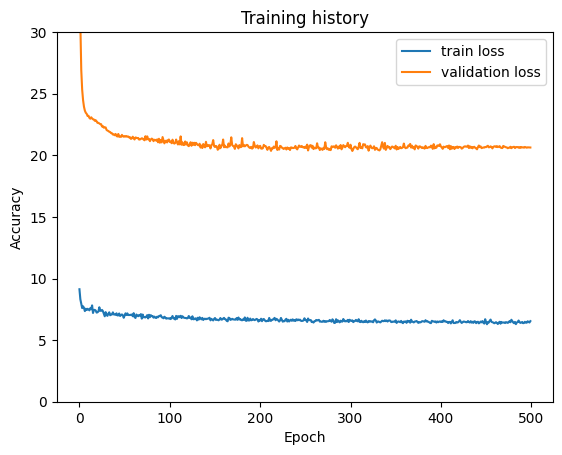

In [116]:
import matplotlib.pyplot as plt

#Plot training and validation accuracy
plt.plot(history["train_loss"], label='train loss')
plt.plot(history["valid_loss"], label='validation loss')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 30]);
print(best_valid_loss)

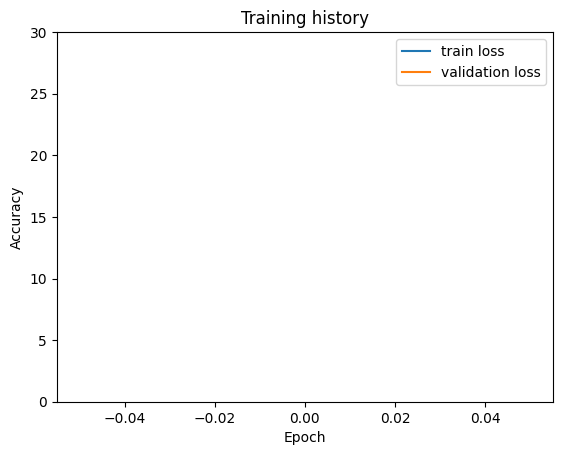

In [117]:
#Plot training and validation accuracy
plt.plot(history["train_loss"][2000:2500], label='train loss')
plt.plot(history["valid_loss"][2000:2500], label='validation loss')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 30]);

In [118]:
def prevision_mocap(model, input_mocap, device, max_output_length):
    model.eval()
    with torch.no_grad():
        input_mocap = torch.tensor(input_mocap).float().to(device)
        # input_mocap = [50, 57]
        input_mocap = input_mocap.unsqueeze(1)
        # input_mocap = [50, 1, 57]
        
        hidden, cell = model.encoder(input_mocap)
        # input_mocap = [1, 1, hidden_dim]
        # input_mocap = [1, 1, hidden_dim]

        input_mocap = input_mocap.squeeze(1)
        # input_mocap = [50, 57]
        previsions = [input_mocap[-1].tolist()]

        for _ in range(max_output_length):
            inputs_tensor = torch.tensor([previsions[-1]]).to(device)

            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            # output = [1, 57]
            output = output.tolist()
            previsions.append(output[0])
    
    del previsions[0]
    return np.array(previsions)
stop

NameError: name 'stop' is not defined

In [ ]:
rand_x = random.randint(0, len(frame_vocab_copy))

input_mocap = np.array(frame_vocab_copy.values.tolist()[rand_x][:50])

deleted = input_mocap[:, indexes_to_exclude]

input_mocap_test = np.delete(input_mocap, indexes_to_exclude, axis=1)

expected_output_mocap = np.array(frame_vocab_copy.values.tolist()[rand_x][-25:])

prevision = prevision_mocap(
    model,
    input_mocap_test,
    device,
    max_output_length = expected_output_mocap.shape[0]
)

for i, column in enumerate(deleted[-25:].T):
    prevision = np.insert(prevision, indexes_to_exclude[i], column, axis=1)

input_mocap = input_mocap.reshape(50, 24, 3)
print(input_mocap.shape)

expected_output_mocap = expected_output_mocap.reshape(25, 24, 3)
print(expected_output_mocap.shape)

prevision = prevision.reshape(25, 24, 3)
print(prevision.shape)

(50, 24, 3)
(25, 24, 3)
(25, 24, 3)


In [ ]:
print(len(frame_vocab.iloc[0]), len(frame_vocab[0][0]))
print(len(frame_vocab_copy.iloc[0]), len(frame_vocab_copy[0][0]))

75 57
75 72


In [ ]:

input_mocap = kine.compute_fk(input_mocap, apply_root_rotation=True)
expected_output_mocap = kine.compute_fk(expected_output_mocap, apply_root_rotation=True)
prevision = kine.compute_fk(prevision, apply_root_rotation=True)

motions_list = [[input_mocap], [expected_output_mocap, prevision]]
subplot_ids = [[0], [0,1]]
subplot_titles = [['Input_mocap'], ['Expected_output_mocap', 'Prevision']]
camera_orientations = [[CameraOrientation(100, 20)], [CameraOrientation(100, 20), CameraOrientation(100, 20)]]

pose_animation(motions_list[0], SmplConstants.PARENTS, animation_framerate = 25, subplot_ids=subplot_ids[0], 
               camera_orientations=camera_orientations[0], subplot_titles=subplot_titles[0],
               fig_opts={'dpi':90}, animation_mode=AnimationMode.HTML)

pose_animation(motions_list[1], SmplConstants.PARENTS, animation_framerate = 25, subplot_ids=subplot_ids[1], 
               camera_orientations=camera_orientations[1], subplot_titles=subplot_titles[1],
               animation_mode=AnimationMode.HTML)